# Minimizing Supervision for Free-space Segmentation

http://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w14/Tsutsui_Minimizing_Supervision_for_CVPR_2018_paper.pdf
```
@inproceedings{tsutsui2018minimizing,
  title={Minimizing Supervision for Free-Space Segmentation},
  author={Tsutsui, Satoshi and Kerola, Tommi and Saito, Shunta and Crandall, David J},
  comment = {the first three authors contributed equally},
  booktitle={Conference on Computer Vision and Pattern Recognition (CVPR) Workshop on Autonomous Driving},
  year={2018}
}
```

# Disclaimer

This is just a minimum working example to show how our automatic road mask generation works, which is implemented solely by me (Satoshi Tsutsui). Because I did the work in an internship and  still do not have the company's permission to open source the code, I reproduced from scratch by myself.  For the experiments in the paper, we used other implementation with gpu enabled cupy backed, and the core part is mostly coded by Shunta Saito (my co-author). As far as I recognize, a big difference is the input resolution. While this one use 224 x 224 for input, the paper used higher resolution for superpixels algorithms so that we can get more precise superpixels. 

# Install dependencies

please install the following dependencies
```
conda install --yes numpy scipy matplotlib 
conda install --yes opencv 
conda install --yes scikit-image pillow
conda install --yes pytorch==0.3.1 torchvision -c pytorch
```

In [1]:
import glob
import json
import os
import random
import time
from PIL import Image
import cv2 as cv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from scipy.ndimage import measurements

# Extract Dilated ResNet feature

citation: part of the code taken from the official repo (https://github.com/fyu/drn)

In [2]:
# i copied some images from citiscapes. You have to register officially to get all images.
images = ["aachen_000000_000019_leftImg8bit.png",
         "aachen_000001_000019_leftImg8bit.png",
        "aachen_000002_000019_leftImg8bit.png"
         ]

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import drn as models

#image preprocessing settings
width,height = 224,224
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Scale(256),
    transforms.Lambda(lambda x : x.resize([width,height])),
    transforms.ToTensor(),
    normalize,
])
def image_loader(image_name):
    """load image, returns tensor with batch size of 1"""
    image = Image.open(image_name).convert('RGB')
    image = transform(image).float()
    image = Variable(image)
    image = image.unsqueeze(0)
    return image


model = models.__dict__["drn_c_26"](True)
model.training=False
model.eval()#set to inference mode
model.out_middle = True

img_features = np.zeros([len(images),512, 28, 28])
for i,img_name in enumerate(images):
    x = image_loader(img_name)
    y, features = model(x)
    last_conv_map = features[-1].data.cpu().numpy()[0]
    img_features[i] = last_conv_map

/nfs/tynamo/home/data/vision7/stsutsui/road-segm/conda/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


# Create Superpixels

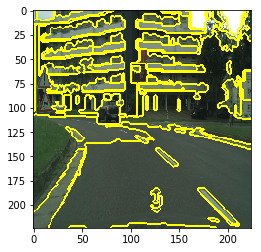

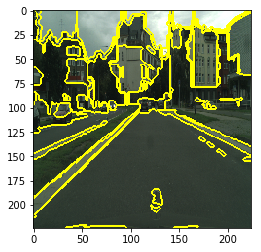

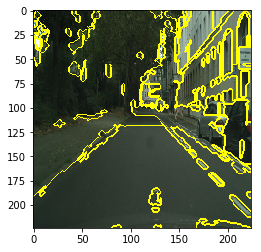

In [4]:
superpixels = []
for i,img_name in enumerate(images):
    img = np.array(Image.open(img_name).convert('RGB').resize([224,224]))
#     img = np.array(Image.open(img_name).convert('RGB'))
    segments = felzenszwalb(img, scale=300, sigma=0.8, min_size=20)
    superpixels.append(segments)
    plt.imshow(mark_boundaries(img,segments))
    plt.show()
superpixels = np.asarray(superpixels)

# Superpixel Alignment (Bilinear Interpolation)

In [5]:
img_features.shape

(3, 512, 28, 28)

In [6]:
# number of points to sample from each superpixel
n_smaples = 10 

#the scaling factor for corrdinate mapping
#(0,0) in input imgage is mapped to (0,0) in feature map
#(223,223) in input image is mapped to (27,27) in feature map 
scaling_factor = 27/223 

#enumerate all possible (x,y) integer corrdinates in advance
all_coords = np.array([[ (cor_y,cor_x) for cor_y in range(28)] for cor_x in range(28)]).reshape(-1,2)

#fetaure of superpixels
#superpixels_features[i][j] is the feature vector for j-th superpixel in i-th imaeg 
superpixels_features = []

for i in range(len(images)):
    #for each image 
    num_superpixel = np.max(superpixels[i])+1
    temp_features = []
    for idx in range(num_superpixel):
        #for each corresponding superpixel
        
        #coordinates of points inside the superpixel
        y_cords,x_cords = np.where(superpixels[i] == idx)
        
        #seelct random 10 points inside the superpixel
        random_indices = np.random.choice(len(y_cords), n_smaples ,replace=False)
        selected_points = np.array([ (y_cords[idx],x_cords[idx]) for idx in random_indices ])
        
        #for each points, apply bilinear interpolation to get corresponding value of feature map
        sp_feature = np.zeros([n_smaples,512])
        for j,p in enumerate(selected_points):
            #cast the point into feature map coordinates
            p = p*scaling_factor
            x,y = p[1],p[0]
            
            #4 neighboring integer coordinates
            x1 = int(x-0.5)
            x2 = x1 + 1
            y1 = int(y-0.5)
            y2 = y1 + 1
            
            #do biliner interplate
            #see https://en.wikipedia.org/wiki/Bilinear_interpolation#/media/File:Bilinear_interpolation_visualisation.svg
            f_x1_y1 = img_features[i,:,y1,x1]
            f_x1_y2 = img_features[i,:,x1,y2]
            f_x2_y1 = img_features[i,:,y1,x2]
            f_x2_y2 = img_features[i,:,y2,x2]
            #assert round((x2 - x) * (y2 - y) + (x - x1) * (y2 - y) + (x2 - x) * (y - y1) + (x - x1) * (y - y1)) == 1
            #assert ((x2 - x1) * (y2 - y1)) == 1
            f = f_x1_y1 * (x2 - x) * (y2 - y)
            f += f_x1_y2 * (x - x1) * (y2 - y)
            f += f_x2_y1 * (x2 - x) * (y - y1)
            f += f_x2_y2 * (x - x1) * (y - y1)
            
            sp_feature[j] = f
        
        #average features from 10 points 
        sp_feature = sp_feature.mean(axis=0)
        
        #append the coordinate of centroid
        mask = superpixels[i] == idx
        centroid = np.array(measurements.center_of_mass(mask))
        sp_feature = np.hstack([sp_feature,centroid])
        
        temp_features.append(sp_feature)
        
    superpixels_features.append(np.array(temp_features))

# Road Prior

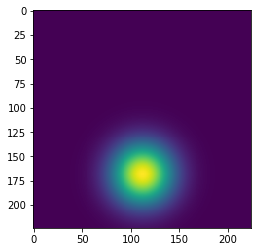

In [7]:
y_rel_pos=0.75
x_rel_pos=0.5
y_rel_sigma=0.1
x_rel_sigma=0.1

ymean = int(height * y_rel_pos)
xmean = int(width * x_rel_pos)
ysigma = height * y_rel_sigma
xsigma = width * x_rel_sigma

x_cords, y_cords = np.meshgrid(np.arange(width), np.arange(height))
road_prior = np.exp(-((x_cords - xmean)**2/(2.*xsigma**2)+(y_cords - ymean)**2/(2.*ysigma**2) ))

plt.imshow(road_prior)
plt.show()

# assign mean road_prior for each superpixel

In [8]:
superpixels_weights = []
for i in range(len(images)):
    #for each image 
    num_superpixel = np.max(superpixels[i])+1
    temp_weights = []
    for idx in range(num_superpixel):
        #for each corresponding superpixel
        mean_weights = np.mean(road_prior[superpixels[i] == idx])
        temp_weights.append(mean_weights)
    temp_weights = np.array(temp_weights)
    superpixels_weights.append(temp_weights)

# Weighted KMeans to obtain estimated road mask

In [9]:
def weighted_kmeans(num_clusters,features,weights,max_iter=100):
    num_data,num_features = features.shape
    assert weights.shape == (250,)

    #assing cluster 1 to k-1
    cls_assign = np.random.randint(num_clusters-1, size=num_data)+1
    #assign cluster 0 if weight is higher than median of the weights
    cls_assign[weights > np.median(weights)] = 0
    
    for _ in range(max_iter):
        #compute new cluster centers
        cls_centers = np.zeros([num_clusters,num_features])
        for i in range(num_clusters):
            if i==0:
                weights_masked = np.zeros(num_data)
                weights_masked[cls_assign==i] = weights[cls_assign==i]
                cls_centers[i] = np.sum(weights_masked[:,None]*features,axis=0)/np.sum(weights_masked)
            else:
                weights_masked = np.zeros(num_data)
                weights_masked[cls_assign==i] = (1-weights)[cls_assign==i]
                cls_centers[i] = np.sum(weights_masked[:,None]*features,axis=0)/np.sum(weights_masked)

        #reassign new clusters
        distances = np.linalg.norm(features[:,None,:] - cls_centers[None,:,:],axis = 2)
#         assert features.shape == (num_data,num_features)
#         assert cls_centers.shape == (num_clusters,num_features)
#         assert distances.shape == (num_data,num_clusters)    
        new_assign = np.argmin(distances,axis = 1)

        #if cluster is not changed, stop
        if np.sum(new_assign - cls_assign) == 0:
            break
        else:
            cls_assign = new_assign
            
    return cls_assign

In [10]:
#organize features and weights into a batch
superpixels_features_batch = []
superpixels_weights_batch = []
batch_info = [] #store (img_index,superpixel_idx) 
for i in range(len(images)):
    #for each image 
    num_superpixel = np.max(superpixels[i])+1
    for j in range(num_superpixel):
        superpixels_features_batch.append(superpixels_features[i][j])
        superpixels_weights_batch.append(superpixels_weights[i][j])
        batch_info.append((i,j))
superpixels_features_batch = np.array(superpixels_features_batch)
superpixels_weights_batch = np.array(superpixels_weights_batch)
        
#run clustering
num_clusters = 4
clusters = weighted_kmeans(num_clusters,superpixels_features_batch,superpixels_weights_batch)
while(np.sum(clusters == 0)==0):
    #if the road cluster is emptry, run again
    clusters = weighted_kmeans(5,superpixels_features_batch,superpixels_weights_batch)
    
#reorganzie the road mask per image from the results
road_masks = np.zeros([len(images),224,224])
for i,cls_idx in enumerate(clusters):
    img_idx,superpixel_idx = batch_info[i]
    if cls_idx==0:
        road_masks[img_idx,:,:] += superpixels[img_idx]==superpixel_idx

# visualize it

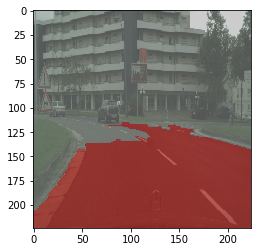

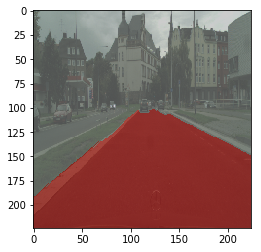

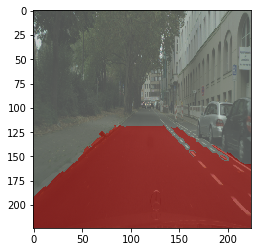

In [11]:
for i,img_name in enumerate(images):
    img = Image.open(img_name).convert('RGB').resize([224,224])
    plt.imshow(img)
    plt.imshow(road_masks[i], cmap=plt.cm.Set1_r, alpha=0.5)
    plt.show()